In [180]:
%config Completer.use_jedi = False
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf, acf
from sklearn.metrics import mean_absolute_error

# 44.04 Milhões de habitantes em SP
SP_POP = 44.04e6

In [151]:
data = pd.read_csv("../data/vacinados_clean.csv", parse_dates=["Data"])
data.head()

,Data,Vacinados,Delta
0,2021-01-19 11:16:00,3908,NaN
1,2021-01-20 14:14:00,17318,13410.0
2,2021-01-20 15:11:00,18409,1091.0
3,2021-01-20 15:19:00,18729,320.0
4,2021-01-20 15:24:00,18834,105.0


In [335]:
train_split = int(data.shape[0] * 0.75)
# conjuntos de treino e teste
train, test = data.iloc[:train_split], data.iloc[train_split:]

def wrangle_data(data, stdev_outlier=2):
    # Eliminando nulos e valores onde a diferença do anterior é menor que 0
    # por que as vezes o site do vacinometro reporta valores errados
    data = data.dropna()
    data = data.drop(data.query("Delta <= 0").index)
    # Vamos remover todas as entradas cuja a diferença
    # da anterior (coluna delta) estiver acima de um certo número de
    # desvios padrões da média (pelo mesmo motivo)
    std = data.Delta.std()
    mean = data.Delta.mean()
    data = data.drop(data.query("Delta > @mean+@stdev_outlier*@std").index)
    # Para cada entrada, calcula em qual hora do ano ela foi computada (24*(dia_do_ano-1) + hora_do_dia)
    # Dia do ano - 1 por que o primeiro dia começa na hora 0
    data["HourOfYear"] = 24*(data.Data.dt.dayofyear-1) + data.Data.dt.hour
    # Agrupa registros q aconteceram dentro da mesma hora e soma todas as mudanças
    # Isso vai 'estacionarizar' nossos dados
    #vacinados_hora = data.groupby("HourOfYear").sum()["Delta"]
    vacinados_hora = data.groupby("HourOfYear").max()["Vacinados"]
    
    return vacinados_hora

train = wrangle_data(train)
test = wrangle_data(test)

# Modelo SarimaX

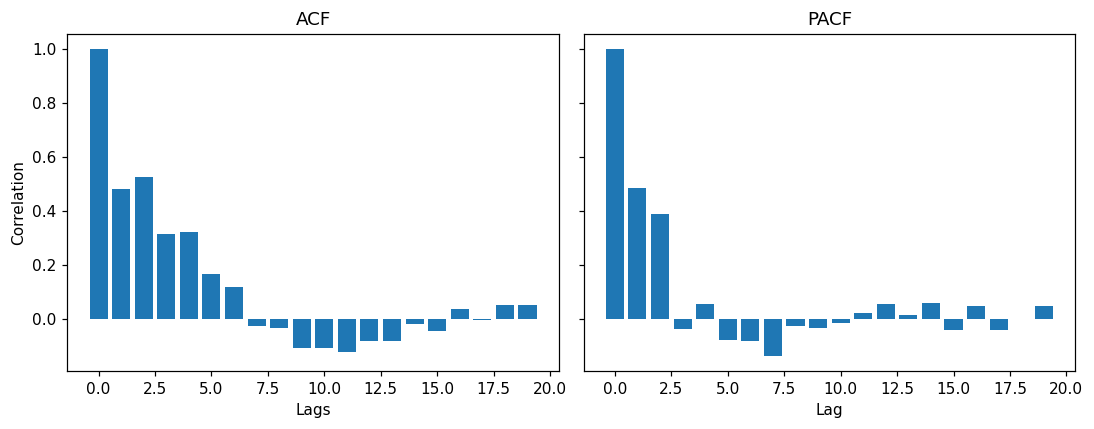

In [353]:
first_diff = vacinados_hora.diff()[1:]
num_lags = 20
acf_vals = acf(first_diff, nlags=num_lags, fft=False)
pacf_vals = pacf(first_diff, nlags=num_lags)

fig, ax = plt.subplots(ncols=2, figsize=(10,4), dpi=110, sharey=True)

ax[0].bar(range(num_lags), acf_vals[:num_lags])
ax[0].set(title="ACF",
         xlabel="Lags",
         ylabel="Correlation")

ax[1].bar(range(num_lags), pacf_vals[:num_lags])
ax[1].set(title="PACF",
         xlabel="Lag")
fig.tight_layout();

In [372]:
opt_param = {'method': 'powell', 'maxiter':150}

def train_score_sarima(order, seasonal_order, train, test):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    fit  = model.fit(**opt_param)
    predictions = fit.forecast(len(test))
    return mean_absolute_error(test, predictions)

def search_seasonal_period(order, P, Q, D, train, test, periods):
    best_score = None
    best_m = None
    for m in periods:
        score = train_score_sarima(order, (P,Q,D,m), train, test)
        if best_score is None or score < best_score:
            best_m, best_score = m, score
    return best_m, best_score

In [373]:
best_m, best_score = search_seasonal_period(order, 1,1,1, list(train), list(test), range(16,30))
best_m, best_score

Optimization terminated successfully.
         Current function value: 7.561362
         Iterations: 3
         Function evaluations: 345
Optimization terminated successfully.
         Current function value: 7.532544
         Iterations: 7
         Function evaluations: 834
Optimization terminated successfully.
         Current function value: 7.472946
         Iterations: 3
         Function evaluations: 354


/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 7.267378
         Iterations: 3
         Function evaluations: 347
Optimization terminated successfully.
         Current function value: 7.098040
         Iterations: 6
         Function evaluations: 700


/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 7.097173
         Iterations: 8
         Function evaluations: 929


/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 7.021887
         Iterations: 7
         Function evaluations: 821


/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 6.953800
         Iterations: 9
         Function evaluations: 1044


/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 6.891739
         Iterations: 7
         Function evaluations: 823


/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 6.747862
         Iterations: 8
         Function evaluations: 952


/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 6.713621
         Iterations: 6
         Function evaluations: 715
Optimization terminated successfully.
         Current function value: 6.605843
         Iterations: 8
         Function evaluations: 942


/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 6.620576
         Iterations: 7
         Function evaluations: 829


/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 6.512736
         Iterations: 6
         Function evaluations: 707


(23, 20240.977899680296)

In [374]:
# Analise usadno modelo Sarimax
# 6 lags pelo gráfico de ACF, 1 diferença nos deixou estacionários
order=(6,1,1)
season_order=(1, 1, 1, best_m)
model =SARIMAX(list(train), order=order, seasonal_order=season_order)
model_fit = model.fit(**opt_param)

/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/phyrlae/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 6.953800
         Iterations: 9
         Function evaluations: 1044


In [364]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  110
Model:             SARIMAX(6, 1, 1)x(1, 1, 1, 23)   Log Likelihood                -764.918
Date:                            Wed, 27 Jan 2021   AIC                           1549.836
Time:                                    20:55:06   BIC                           1574.379
Sample:                                         0   HQIC                          1559.714
                                            - 110                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1742      1.448     -0.120      0.904      -3.012       2.663
ar.L2          0.4340      0.380      1.143      0.253      -0.310       1.178
ar.L3          0.1079      0.476      0.226      0.821      -0.826       1.042
ar.L4          0.1890      0.113      1.668      0.095      -0.033       0.411
ar.L5          0.0447      0.348      0.128      0.898      -0.638       0.727
ar.L6          0.0223      0.117      0.191      0.848      -0.207       0.251
ma.L1          0.4439      1.437      0.309      0.757      -2.373       3.261
ar.S.L23       0.1287      0.122      1.055      0.291      -0.110       0.368
ma.S.L23      -0.8430      0.196     -4.291      0.000      -1.228      -0.458
sigma2      2.618e+06   1.74e-06   1.51e+12      0.000    2.62e+06    2.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 6.77
Prob(Q):                              0.59   Prob(JB):                         0.03
Heteroskedasticity (H):               0.13   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.86e+27. Standard errors may be unstable.
"""

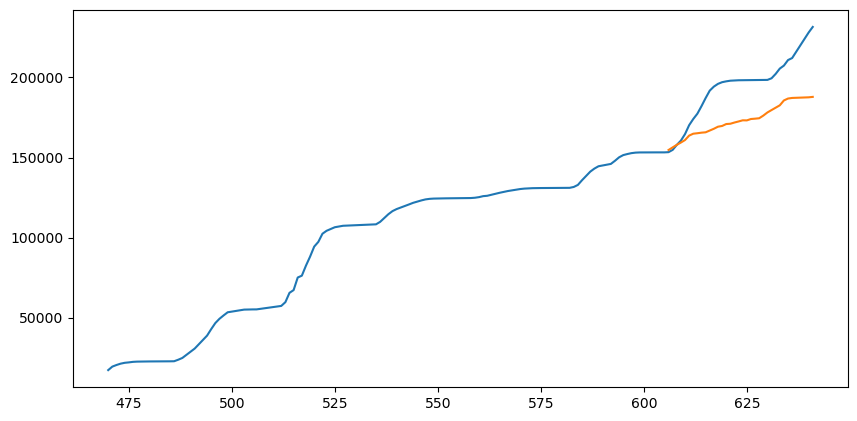

In [365]:
predictions = model_fit.forecast(len(test))
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.plot(vacinados_hora.index, vacinados_hora)
ax.plot(test.index, predictions);

In [376]:
# Analise usadno modelo Sarimax
# 6 lags pelo gráfico de ACF, 1 diferença nos deixou estacionários
full_data = wrangle_data(data)
order=(6,1,1)
season_order=(1, 1, 1, best_m)
model =SARIMAX(list(full_data), order=order, seasonal_order=season_order)
model_fit = model.fit(**opt_param)

Optimization terminated successfully.
         Current function value: 7.509911
         Iterations: 5
         Function evaluations: 590


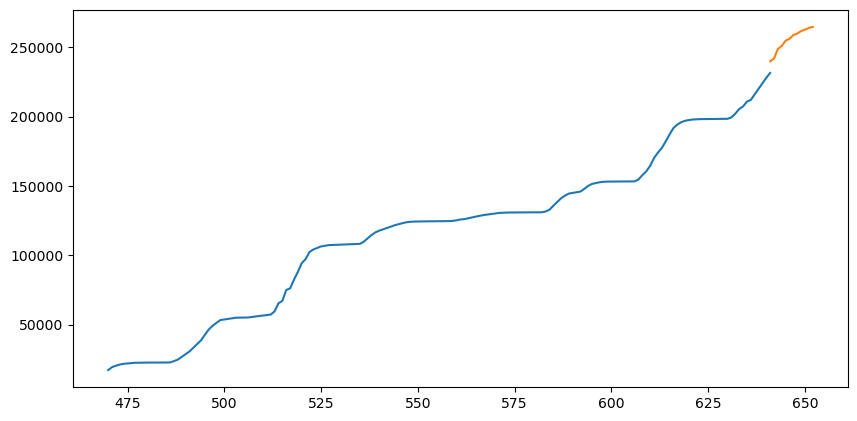

In [379]:
predictions = model_fit.forecast(12)
index = range(full_data.index.max(), full_data.index.max()+12)
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.plot(vacinados_hora.index, vacinados_hora)
ax.plot(index, predictions);